<h1 align = center> <b> Reinforcement Learning (M2 MOSIG / MSIAM)<h1>

<h1 align = center>  Lab 2: Temporal Difference Learning: Q-Learning and SARSA <h1>


## Introduction

The purpose of this lab is to practice with *Temporal Difference Learning* method (i.e., *TD Learning*); including two methods: *Q-Learning* and *SARSA*.

We prepare the libraries needed for this lab by running the next 3 cells:

$
\newcommand{\vs}[1]{\mathbf{#1}} % vector symbol (\boldsymbol, \textbf or \vec)
\newcommand{\ms}[1]{\mathbf{#1}} % matrix symbol (\boldsymbol, \textbf)
\newcommand{\prob}{\mathbb{P}}
\def\U{V}
\def\action{\vs{a}}       % action
\def\A{\mathcal{A}}        % TODO
\def\actionset{\mathcal{A}} %%%
\def\discount{\gamma}  % discount factor
\def\state{\vs{s}}         % state
\def\S{\mathcal{S}}         % TODO
\def\stateset{\mathcal{S}}  %%%
%
\def\E{\mathbb{E}}
%\newcommand{transition}{T(s,a,s')}
%\newcommand{transitionfunc}{\mathcal{T}^a_{ss'}}
\newcommand{transitionfunc}{P}
\newcommand{transitionfuncinst}{P(\nextstate|\state,\action)}
\newcommand{transitionfuncpi}{\mathcal{T}^{\pi_i(s)}_{ss'}}
\newcommand{rewardfunc}{r}
\newcommand{rewardfuncinst}{r(\state,\action,\nextstate)}
\newcommand{rewardfuncpi}{r(s,\pi_i(s),s')}
\newcommand{statespace}{\mathcal{S}}
\newcommand{statespaceterm}{\mathcal{S}^F}
\newcommand{statespacefull}{\mathcal{S^+}}
\newcommand{actionspace}{\mathcal{A}}
\newcommand{reward}{R}
\newcommand{statet}{S}
\newcommand{actiont}{A}
\newcommand{newstatet}{S'}
\newcommand{nextstate}{\state'}
\newcommand{newactiont}{A'}
\newcommand{stepsize}{\alpha}
\newcommand{discount}{\gamma}
\newcommand{qtable}{Q}
\newcommand{finalstate}{\state_F}
%
\newcommand{\vs}[1]{\boldsymbol{#1}} % vector symbol (\boldsymbol, \textbf or \vec)
\newcommand{\ms}[1]{\boldsymbol{#1}} % matrix symbol (\boldsymbol, \textbf)
\def\vit{Value Iteration}
\def\pit{Policy Iteration}
\def\discount{\gamma}  % discount factor
\def\state{\vs{s}}         % state
\def\S{\mathcal{S}}         % TODO
\def\stateset{\mathcal{S}}  %%%
\def\cstateset{\mathcal{X}} %%%
\def\x{\vs{x}}                    % TODO cstate
\def\cstate{\vs{x}}               %%%
\def\policy{\pi}
\def\piparam{\vs{\theta}}         % TODO pparam
\def\action{\vs{a}}       % action
\def\A{\mathcal{A}}        % TODO
\def\actionset{\mathcal{A}} %%%
\def\caction{\vs{u}}       % action
\def\cactionset{\mathcal{U}} %%%
\def\decision{\vs{d}}       % decision
\def\randvar{\vs{\omega}}       %%%
\def\randset{\Omega}       %%%
\def\transition{T}       %%%
\def\immediatereward{r}    %%%
\def\strategichorizon{s}    %%% % TODO
\def\tacticalhorizon{k}    %%%  % TODO
\def\operationalhorizon{h}    %%%
\def\constalpha{a}    %%%
\def\U{V}              % utility function
\def\valuefunc{V}
\def\X{\mathcal{X}}
\def\meu{Maximum Expected Utility}
\def\finaltime{T}
\def\timeindex{t}
\def\iterationindex{i}
\def\decisionfunc{d}       % action
\def\mdp{\text{MDP}}
$

**Notice**: this notebook requires the following libraries: OpenAI *Gym*, NumPy, Pandas and Seaborn. There are two options:

  * If you want to run this notebook in your local machine, you can install them with the following command (and ignore the next cell):

``
pip install gym numpy pandas seaborn
``

  * Alternatively, if you want to run this notebook on Google Colab, just run the next cell. 

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import math
import gym
import numpy as np
import copy
import pandas as pd
import seaborn as sns
sns.set_context("talk")

## Setup the FrozenLake toy problem with OpenAI Gym

Similar to Lab1, we will use the FrozenLake toy problem as a testbed for our algorithms. A quick remind of FrozenLake is as follows (for more details, please refer to Lab 1's notebooks):

In [2]:
## Load the FrozenLake environment, its states and actions:
env = gym.make('FrozenLake-v1')
# env = gym.make('FrozenLake-v1') ## Uncommentize this if you install the latest version of GymAI on your computer
states = list(range(env.observation_space.n))
actions = list(range(env.action_space.n))
is_final_array = np.full(shape=len(states), fill_value=np.nan, dtype=np.bool)
reward_array = np.full(shape=len(states), fill_value=np.NINF)                # np.NINF = negative infinity
transition_array = np.zeros(shape=(len(states), len(actions), len(states)))
for state in states:
    for action in actions:
        for next_state_tuple in env.P[state][action]:              # env.P[state][action] contains the next states list (a list of tuples)
            transition_probability, next_state, next_state_reward, next_state_is_final = next_state_tuple
            is_final_array[next_state] = next_state_is_final
            reward_array[next_state] = max(reward_array[next_state], next_state_reward)   # workaround: when we already are in state 15, reward is 0 if we stay in state 15 (in practice this never append as the simulation stop when we arrive in state 15 as any other terminal state)
            transition_array[state, action, next_state] += transition_probability
action_labels = { 0: "Move Left",   1: "Move Down",    2: "Move Right",    3: "Move Up"}
# For visualizing the environment
try: env.render()
except:pass # render not available
print('\n', 'states: ', states)
print('action name convetion', action_labels)
print('Reward:' ,reward_array)
print('Is final state:', is_final_array)



SFFF
FHFH
FFFH
HFFG

 states:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
action name convetion {0: 'Move Left', 1: 'Move Down', 2: 'Move Right', 3: 'Move Up'}
Reward: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Is final state: [False False False False False  True False  True False False False  True
  True False False  True]



<img src="https://raw.githubusercontent.com/dongquan-vu/teaching/main/FrozenLake_trans.PNG" style="float: left; width: 90%" />

#### **Important Remark:**
* In Lab1, we work with **model-based** methods: the learning agent "knows" the transition probabilities and the rewards; more precisely, it can "*ask for expectation*".

* **In this lab, we work with model-free** methods: this time, we assume that the learning agent *does not know* the world set-up; it can only "*ask for a sample of the next state and reward*". 

#### Extra functions for displaying results:

In the next cell, we write two function for displaying the states and Qtables in the FrozenLake environment.

In [3]:
def qtable_display(q_array, title=None, figsize=(4,4), annot=True, fmt="0.1f", linewidths=.5, square=True, cbar=False, cmap="Reds"):
    num_actions = q_array.shape[1]
    global_figsize = list(figsize)
    global_figsize[0] *= num_actions
    fig, ax_list = plt.subplots(ncols=num_actions, figsize=global_figsize)   # Sample figsize in inches
    for action_index in range(num_actions):
  
        ax = ax_list[action_index]
        state_seq = q_array.T[action_index]
        states_display(state_seq, title=None, figsize=figsize, annot=True, fmt="0.1f", linewidths=.5, square=True, cbar=False, cmap="Reds", ax=ax)
    plt.suptitle(title)
    plt.show()

In [4]:
def states_display(state_seq, title=None, figsize=(5,5), annot=True, fmt="0.1f", linewidths=.5, square=True, cbar=False, cmap="Reds", ax=None):
    size = int(math.sqrt(len(state_seq)))
    state_array = np.array(state_seq)
    state_array = state_array.reshape(size, size)
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)         # Sample figsize in inches
    sns.heatmap(state_array, annot=annot, fmt=fmt, linewidths=linewidths, square=square, cbar=cbar, cmap=cmap, ax=ax)
    if title is not None:     plt.title(title)
    if ax is None: plt.show()
    else: return ax

# Section 1: Temporal Difference for Value Estimation

## TD-LEARNING algorithm:

Recall: In order to evaluate a policy $\pi$, in previous lab:
* Bellman Equation:
 $$
  \U_{\pi}(s) = \mathbb{E} \left[ \reward(S_{t+1}) + \discount \U_{\pi}(S_{t+1}) | S_t = \state, A_t \sim \pi(\state) \right]
  $$

* In Lab1: approximating $\U_{\pi}$ by interating (turning Bellman's equation into an update rule) 
    \begin{equation}
      \U_{t+1}(\state) =   \mathbb{E} \left[ \reward(S_{t+1}) + \discount \U_{k}(S_{t+1}) | S_t = \state, A_t \sim \pi(\state) \right] .
    \end{equation}

 <h4 align = center> <b> Key question: How to approximate Value Function using model-free methods?<h4>



* Cannot find $\mathbb{E}$, can we use a **sample** instead: $\U_{t}(s) = \overbrace{R(S_{t+1}) + \gamma \U_{k}(S_{t+1})}^{\textrm{get from sampling}}$?

 $\Rightarrow$ This is likely very noisy. 

* **The main idea of TD-Learning:** Take a small step---controled via parameter $\alpha$---by using the temporal difference:

\begin{equation}
      \U_{t+1}(S_{k+1}) =  \U_{k}(S_t) + \alpha \cdot \left[\underbrace{\overbrace{\reward(S_{t+1}) + \discount \U_{k}(S_{t+1})}^{\textrm{target}} - \U_{k}(S_t)}_{\textrm{called the TD error}} \right] .
\end{equation}
Use this to update the Value Approximation.

PSEUDO-CODE OF TD LEARNING:


**Input**:$\quad\quad$ policy $\policy$ (to be evaluated), step size $\stepsize \in (0,1]$

**Initialize** $\valuefunc(\state)=0, \forall \state \in \statespace$<br>

<b>FOR EACH</b> episode<br>
	$\quad$ $\statet \leftarrow \text{env.reset}()$<br>
	$\quad$ <b>DO the following <b>UNTIL</b> $\statet$ is final:</b> <br>
		$\quad\quad$ $\actiont \leftarrow \pi(\statet)$<br>
		$\quad\quad$ $\newstatet, \reward \leftarrow \text{env.step}(\actiont)$<br>
		$\quad\quad$ $\valuefunc(\statet) \leftarrow \valuefunc(\statet) + \stepsize \left[ \reward + \discount ~ \valuefunc(\newstatet) ~ - ~ \valuefunc(\statet) \right]$<br>
		$\quad\quad$ $\statet \leftarrow \newstatet$<br>
	$\quad$ 

In the next cell, the TD-learning algorithm is prepared:

**Notice**: New syntax of Gym (particularly, FrozenLake):
* ```s = env.reset()```: assign the starting state to variable ```s```
* ``` new_state, reward, is_final_state, info = env.step(A)```: sample the next state when doing action ```A```.

In [5]:
DISPLAY_EVERY_N_EPISODES = 50
def td_learning(policy, env, alpha_init=0.1, gamma=0.95, num_episodes=1000, display=False,alpha_factor=0.95):
    num_states = env.observation_space.n
    v_array = np.zeros(num_states)   # Initial value function
    alpha = alpha_init
    
    for episode_index in range(num_episodes):
        #alpha = 0.998/(1+2*episode_index)
        alpha = pow(0.998,episode_index)
        # For displaying purpose
        if display and episode_index % DISPLAY_EVERY_N_EPISODES == 0:
            states_display(v_array, title="Value function (ep. {})".format(episode_index), cbar=True, cmap="Reds")
        else: print('', end="")
        value_function_history.append(v_array.copy())
        alpha_history.append(alpha)
        # End of displaying purpose            

        
        state = env.reset()
        is_final_state = False

        while not is_final_state:
            action = policy[state]
            new_state, reward, is_final_state, info = env.step(action)
            ##################
            # TD-LEARNING UPDATE
            v_array[state] = v_array[state] + alpha * (reward + gamma * v_array[new_state] - v_array[state])
            
            state = new_state
    
    return v_array

## Exercise 1: **The role of step-size $\alpha$:**



Now, we aim to test the ```td_learning``` algorithm by evaluating a specific policy (given in the next cell). 

*Remark:* This policy is actually the greedy_policy obtained from our (near) optimal value function in Lab1 (note again that in Lab1, the rewards and transition probablities are given a priori). The *target* values corresponding to this policy is: 
<img src="https://raw.githubusercontent.com/dongquan-vu/teaching/main/Opt_Value_FrozenLake.PNG" style="float: left" width="400px"/>
 


**In the next cell,** we run the td_learning algorithm and display the value function that it learnt. Then, we plot out the evolution of the value at each state and the evolution of the stepsize $\alpha$.


## Question 1.1

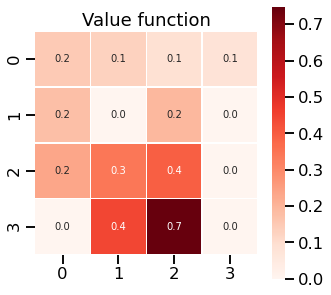

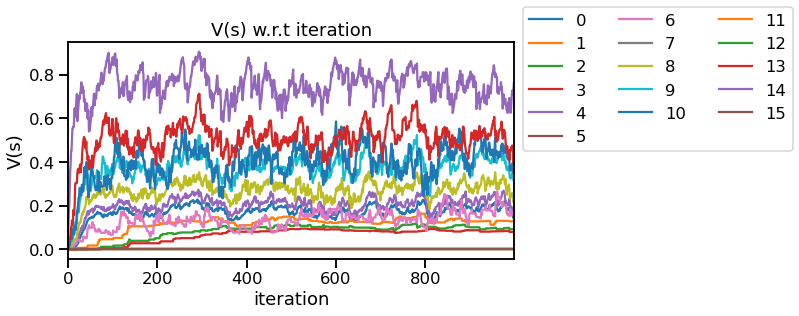

In [114]:

alpha_history = []
value_function_history=[]
policy = [0, 3, 3, 3,
          0, 0, 0, 0,
          3, 1, 0, 0,
          0, 2, 1, 0]
env._max_episode_steps = 10000
# TD-Learning:
v_array = td_learning(policy, env, 0.1, display=False)
env.close()
# Display the value function
states_display(v_array, title="Value function", cbar=True, cmap="Reds")
# Plot out the evolution of value at each state
value_function_last.append(v_array.copy())
df_v_hist = pd.DataFrame(value_function_history)
df_v_hist.plot(figsize=(8,4))
plt.title("V(s) w.r.t iteration")
plt.ylabel("V(s)")
plt.xlabel("iteration")
plt.legend(bbox_to_anchor=(1,1.2), ncol = 3);
plt.show()



## Question 1.2

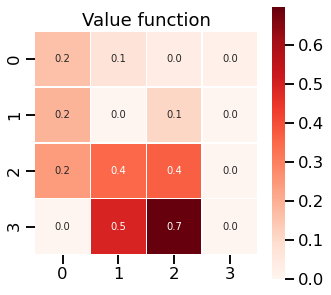

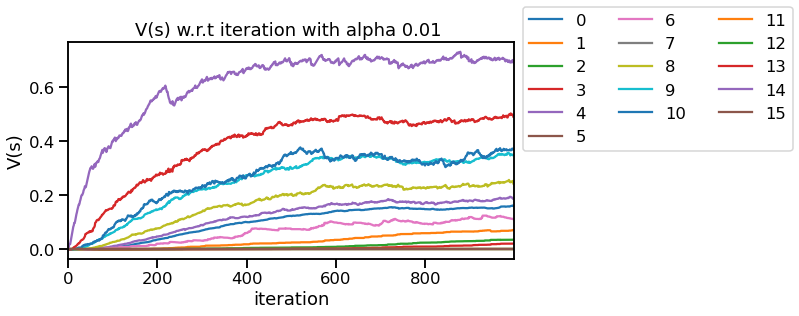

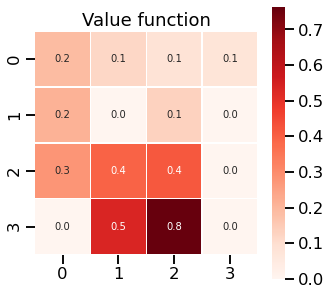

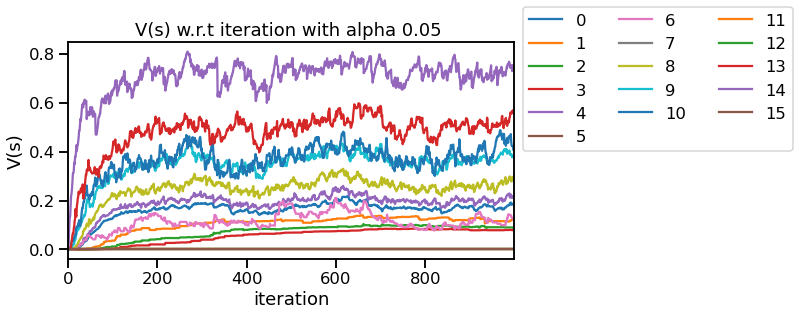

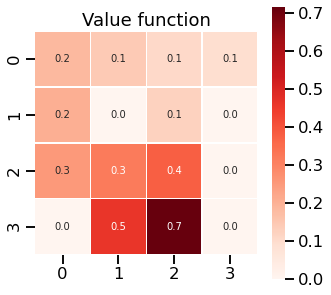

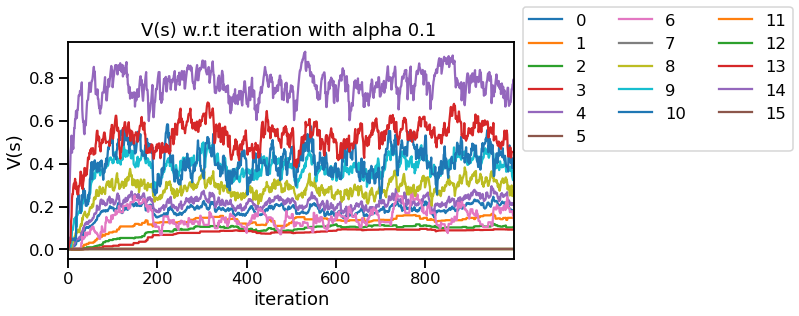

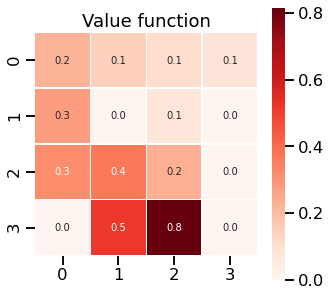

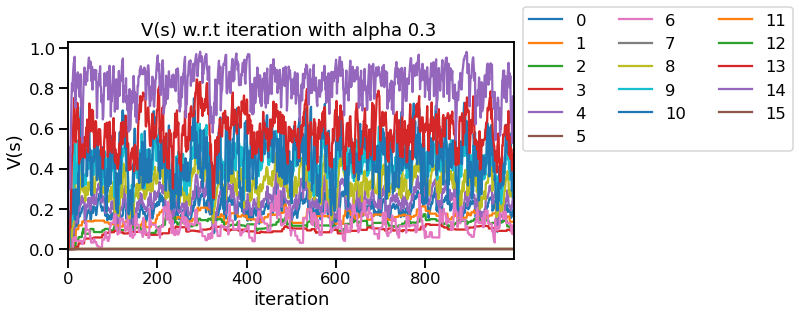

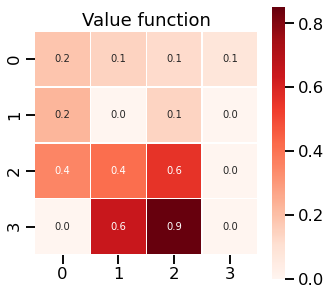

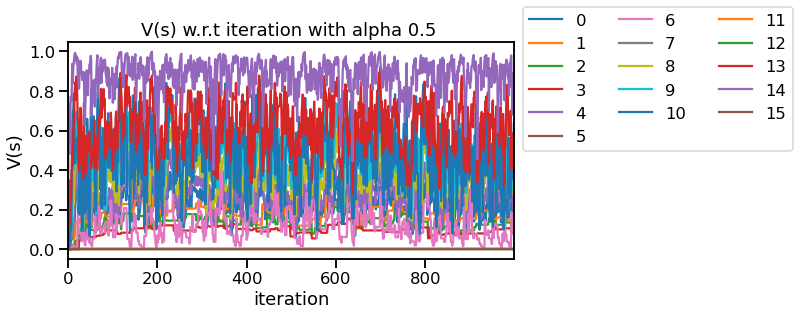

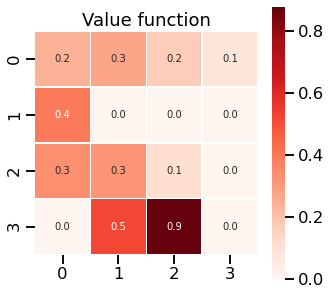

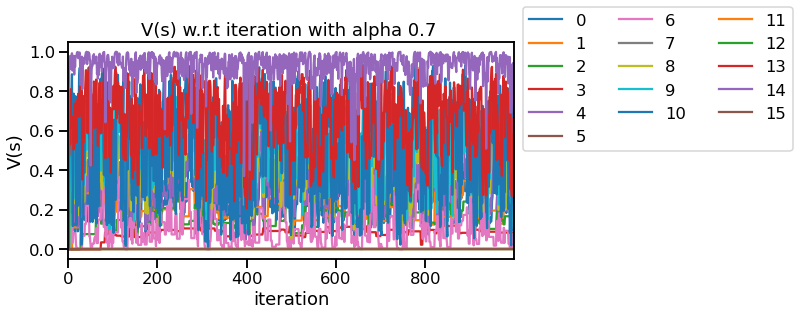

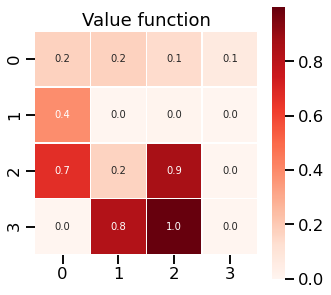

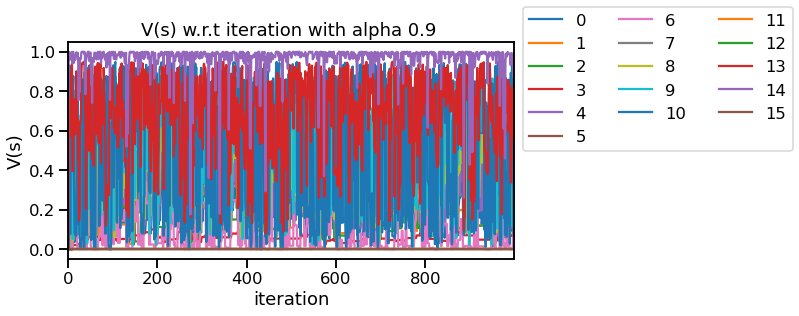

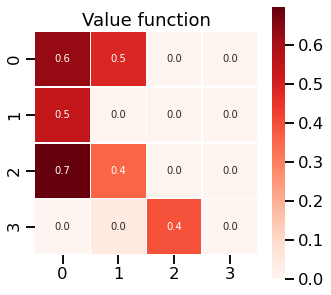

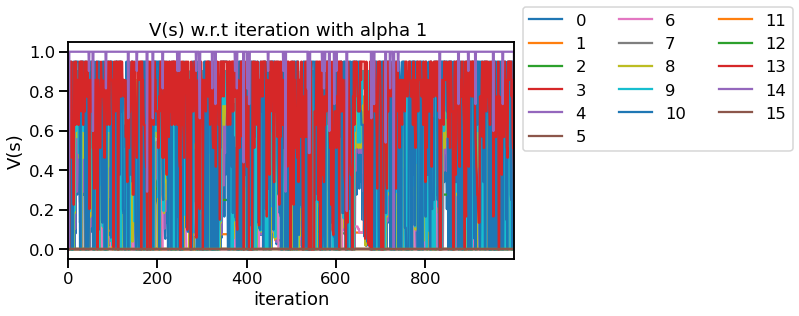

In [119]:
alpha_values =  [0.01, 0.05, 0.1 ,0.3, 0.5, 0.7, 0.9, 1]
value_function_last = []
for alpha_init in alpha_values:
    value_function_history = []
    alpha_history = []
    
    policy = [0, 3, 3, 3,
              0, 0, 0, 0,
              3, 1, 0, 0,
              0, 2, 1, 0]
    env._max_episode_steps = 10000
    # TD-Learning:
    v_array = td_learning(policy, env, alpha_init, display=False)
    env.close()
    # Display the value function
    states_display(v_array, title="Value function", cbar=True, cmap="Reds")
    # Plot out the evolution of value at each state
    value_function_last.append(v_array.copy())
    #print("last values", value_function_last)
    df_v_hist = pd.DataFrame(value_function_history)
    df_v_hist.plot(figsize=(8,4))
    plt.title("V(s) w.r.t iteration with alpha {} ".format(alpha_init))
    plt.ylabel("V(s)")
    plt.xlabel("iteration")
    plt.legend(bbox_to_anchor=(1,1.2), ncol = 3);
    plt.show()

 

              0         1         2         3         4    5         6    7   \
0.01    0.161249  0.072142  0.036218  0.021454  0.189969  0.0  0.110811  0.0   
0.05    0.188715  0.119862  0.085337  0.077163  0.213851  0.0  0.133143  0.0   
0.1     0.184010  0.144041  0.108731  0.092284  0.205164  0.0  0.124705  0.0   
0.3     0.222683  0.145361  0.108333  0.085635  0.278306  0.0  0.075862  0.0   
0.5     0.183582  0.144871  0.121169  0.078733  0.227221  0.0  0.142139  0.0   
0.7     0.245147  0.279899  0.167688  0.085059  0.396804  0.0  0.002052  0.0   
0.9     0.172249  0.173549  0.138902  0.069239  0.392269  0.0  0.009720  0.0   
1       0.630249  0.487675  0.000000  0.000000  0.540360  0.0  0.000000  0.0   
target  0.500000  0.500000  0.500000  0.500000  0.600000  0.0  0.400000  0.0   

              8         9         10   11   12        13        14   15  
0.01    0.240902  0.350949  0.369835  0.0  0.0  0.493390  0.697310  0.0  
0.05    0.278444  0.395918  0.417474  0.0  0.0  0.5

C:\Users\SNOW\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1182: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


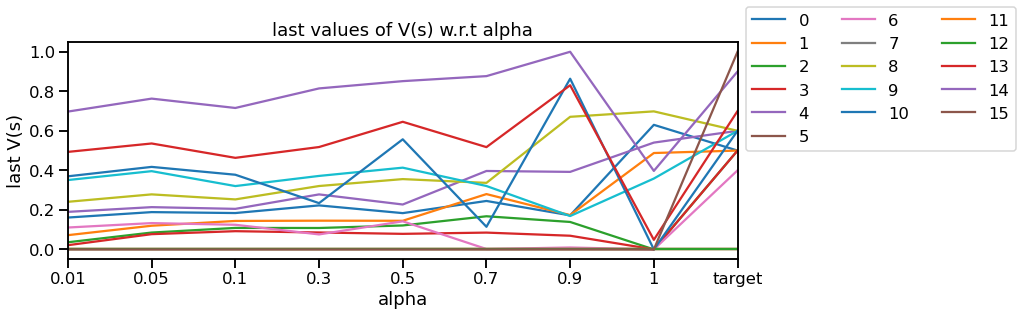

In [121]:
alpha_values_str = [str(i) for i in alpha_values]
df_v_hist_alpha = pd.DataFrame(value_function_last, index = alpha_values_str, columns =states)
df_v_hist_alpha.loc["target"] = [0.5, 0.5, 0.5, 0.5, 0.6, 0.0, 0.4, 0.0, 0.6, 0.6, 0.6, 0.0, 0.0, 0.7, 0.9, 1.0]
print(df_v_hist_alpha )
df_v_hist_alpha.reset_index().plot(x='index', figsize=(12,4))
#plt.xticks(df_v_hist_alpha.index, alpha_values_str)

plt.title("last values of V(s) w.r.t alpha")
plt.ylabel("last V(s)")
plt.xlabel("alpha")
plt.legend(bbox_to_anchor=(1,1.2), ncol = 3);
plt.show()

## Question 1.3: Exponential

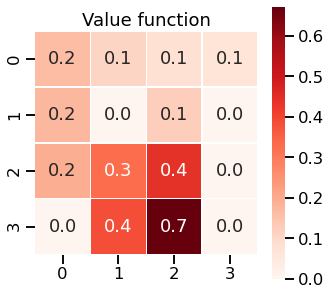

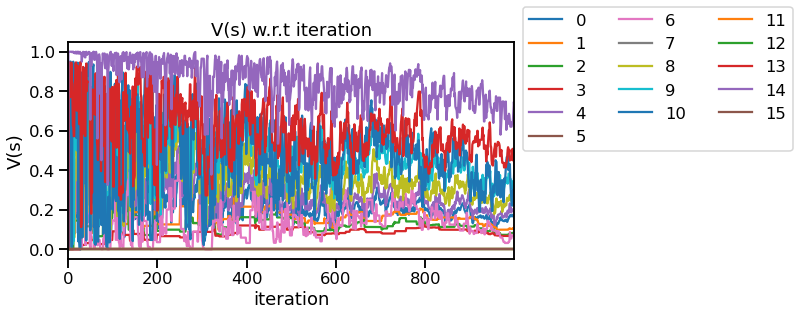

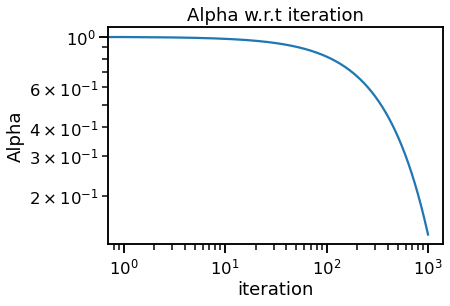

In [169]:
alpha_history = []
value_function_history=[]
policy = [0, 3, 3, 3,
          0, 0, 0, 0,
          3, 1, 0, 0,
          0, 2, 1, 0]
env._max_episode_steps = 10000
# TD-Learning:
v_array = td_learning(policy, env, 0.1, display=False )
env.close()
# Display the value function
states_display(v_array, title="Value function", cbar=True, cmap="Reds")
# Plot out the evolution of value at each state
value_function_last.append(v_array.copy())
df_v_hist = pd.DataFrame(value_function_history)
df_v_hist.plot(figsize=(8,4))
plt.title("V(s) w.r.t iteration")
plt.ylabel("V(s)")
plt.xlabel("iteration")
plt.legend(bbox_to_anchor=(1,1.2), ncol = 3);
plt.show()

# Plotting the evolution of step-size alpha
plt.loglog(alpha_history)
plt.title("Alpha w.r.t iteration")
plt.ylabel("Alpha")
plt.xlabel("iteration");
plt.show()

## Question 1.3: Linear

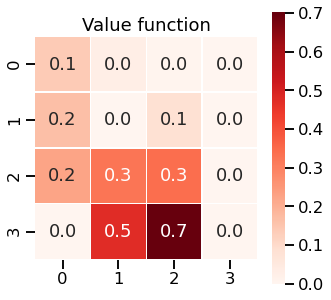

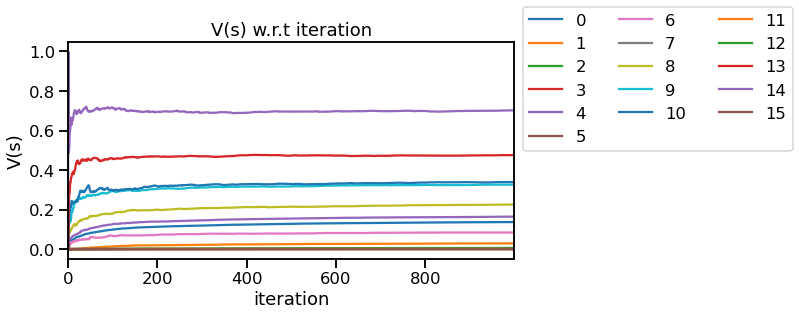

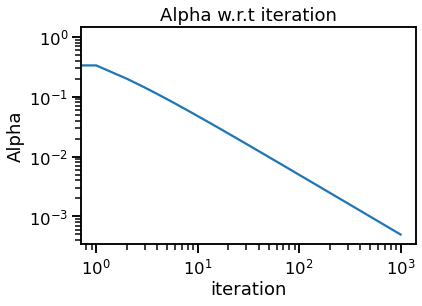

In [138]:
alpha_history = []
value_function_history=[]
policy = [0, 3, 3, 3,
          0, 0, 0, 0,
          3, 1, 0, 0,
          0, 2, 1, 0]
env._max_episode_steps = 10000
# TD-Learning:
v_array = td_learning(policy, env, 0.1, display=False )
env.close()
# Display the value function
states_display(v_array, title="Value function", cbar=True, cmap="Reds")
# Plot out the evolution of value at each state
value_function_last.append(v_array.copy())
df_v_hist = pd.DataFrame(value_function_history)
df_v_hist.plot(figsize=(8,4))
plt.title("V(s) w.r.t iteration")
plt.ylabel("V(s)")
plt.xlabel("iteration")
plt.legend(bbox_to_anchor=(1,1.2), ncol = 3);
plt.show()

# Plotting the evolution of step-size alpha
plt.loglog(alpha_history)
plt.title("Alpha w.r.t iteration")
plt.ylabel("Alpha")
plt.xlabel("iteration");
plt.show()

**QUESTION 1.1:** 

1/ What is your observation on the evolution of value approximation? 
Do you think this is a good estimation of the target values given above? 

2/ Go back to the previous cell, run the TD-learning algorithm with smaller/larger parameter ```alpha```. How do you think ```alpha``` affects the evolution of values at states?

3/ Go back to the cell defining ```td_learning``` algorithm and modify it such that the step-size alpha is a **decreasing sequence** as ```episode_index``` increases. Particularly, you can try several options as follows:
  * (a) ```alpha``` decreases linearly: at each ```episode_index```, set ```alpha =``` $\frac{a}{1 + b \cdot \textrm{episode_index}}$ where $a < 1$ and $b$ are your chosen parameters. 
  * (b) ```alpha``` decreases exponentially:  at each ```episode_index```, set ```alpha =``` $a^{\textrm{episode_index}} $ where $a < 1$ is your chosen parameter (hint: you should choose $a$ closed to 1). 

Draw your conclusions on: what happens if the step-size $\alpha$ decreases too fast? when it decreases too slow?

**ANSWERS TO QUESTION 1.1:**


1- The value function obtained when applying TD-learning algorithm are not that good comparing to the target values. 
This could be explained by the fact that the target values are obtained using the full backup and also by measuring the expectation $\mathbb{E}$ as showed in Bellman equation. And because we can not determine $\mathbb{E}$, then the model free method (td learning) measures an approximation of the expectation using only a sample of the backup to evaluate the policy  $\policy$ without improving it after each iteration (episode). 


2- As showed in the figure named "last values wrt to alpha", almost all values function of each state are close to the target values for alpha between $[0.3, 0.5]$ which means that best approximation values are obtained for these value of alpha. 
For the same number of iterations:
    . When $\alpha$ is too small, it explores the environment too slowly (the small oscillations in the graphs of $v(s)$ w.r.t $\alpha = 0.01$ and $\alpha=0.05$ prove it) which means that it does not reach the minima only if we increase the number of iterations.
    . When instead $\alpha$ is too large, it continuously oscillates around the minima as showed in the graphs of $v(s)$ w.r.t $\alpha = 0.7, 0.9, 1$ and diverges from the optimal solution as it considers mostly the new values and ignores the old ones.

3- As we can see, the returned values function are much better when alpha decreases exponentially (quickly) because initially when we are at a totally random point in solution space we need to take big leaps towards the solution and later when we come close to it, we make small jumps and hence small improvements to finally reach the minima. However, when it decreases linearly, the first step is not respected, so leaps taken towrads the solution are not big enough to converge to the minima.


# Section 2: Tabular RL & Policy improvement


## Preliminary functions:


In the next cell, two functions are coded for finding the nearly optimal policy based on the value estimated by td_learning. Particularly, we implement the *greedy* and the $\epsilon$-*greedy* policies that agents will used to explore the environment and update their QTable:

$Q^{\pi}(s, a) =$ expected value when playing action $a$ at state $s$. 

QTable = a matrix (size $(|\mathcal{S}| \times |\mathcal{A}|)$) storing the current estimated Q-value. 


$\displaystyle \policy^{Q^{\pi}}(\statet) := \text{greedy}(\statet, Q^{\pi}) = \arg\max_{\actiont \in \actionspace} Q^{\pi}(\statet, \actiont)$


$\policy^{Q^{\pi},\epsilon}(\statet) := \epsilon\text{-greedy}(\statet, Q^{\pi}) = $
randomly choose between $\underbrace{\text{greedy}(\statet, Q^{\pi})}_{\text{with probability } 1 - \epsilon}$
and $~~ \underbrace{\text{a random action}}_{\text{with probability } \epsilon}$

In [6]:
def greedy_policy(state, q_array):
    action = np.argmax(q_array[state, :])
    return action
def epsilon_greedy_policy(state, q_array, epsilon):
    if np.random.rand() < epsilon:
        action = np.random.randint(q_array.shape[1])
    else: action = greedy_policy(state, q_array)
    return action

## Exercise 2: Implement the SARSA algorithm

To find the optimal policy (or a nearly optimal policy) for the FrozenLake-v0 problem, we will first use the SARSA algorithm. SARSA has two main elements

* 1) Policy improvement: choose an action via $\varepsilon$-greedy.

* 2) Policy evaluation: Use TD-update (with respect to action chosen  $\varepsilon$-greedy) for Q-value:
$$
Q^{\pi}_{t+1} (s_t , a_t) \leftarrow Q^{\pi}_t(s_t, a_t) + \alpha \left( r_t + \gamma Q^{\pi}_t(s_{t+1}, a_{t+1}) - Q^{\pi}_t(s_t, a_t) \right) ,
$$
$\Rightarrow$ To estimate Q-value of policy $\pi$ $\Rightarrow$ this is called **On-policy** method.

Particularly, a pseudo code of SARSA is as follow:

---
SARSA


<b>Algorithm parameter</b>:	$\quad\quad$ discount factor $\discount$, 	$\quad\quad$ step size $\stepsize \in (0,1]$, 	$\quad\quad$ small $\epsilon > 0$

**Initialize** $\qtable(\state, \action)=0, \forall \state \in \statespace$

<b>FOR EACH</b> episode<br>
	$\quad$ $\statet \leftarrow \text{env.reset}()$<br>
	$\quad$ $\actiont \leftarrow \epsilon\text{-greedy}(\statet, Q)$<br>
$\quad$ <b>DO the following <b>UNTIL</b> $\statet$ is final:</b> <br>		$\quad\quad$ $\reward, \newstatet \leftarrow \text{env.step}(\actiont)$<br>
		$\quad\quad$ $\newactiont \leftarrow \epsilon\text{-greedy}(\newstatet, Q)$<br>
		$\quad\quad$ $Q(\statet,\actiont) \leftarrow Q(\statet,\actiont) + \stepsize \left[ \underbrace{\reward + \discount ~ Q(\newstatet,\newactiont) ~ - ~ Q(\statet,\actiont)}_{\text{TD error}} \right]$<br>
		$\quad\quad$ $\statet \leftarrow \newstatet$<br>
		$\quad\quad$ $\actiont \leftarrow \newactiont$<br>

**QUESTION 2.1**: In the next cell, you need to fill in the blank to implement SARSA. 

In [94]:
DISPLAY_EVERY_N_EPISODES = 50
def sarsa(env, alpha_init=0.1, gamma=0.99, epsilon=0.5, num_episodes=10000, display=False):
    num_states = env.observation_space.n
    num_actions = env.action_space.n
    # Initial Q table (a matrix size num_states x num_actions)
    q_array = np.zeros([num_states, num_actions])   
    accum_reward = 0
    alpha = alpha_init

    for episode_index in range(num_episodes):
        # FOR displaying results
        if display and episode_index % DISPLAY_EVERY_N_EPISODES == 0:
            qtable_display(q_array, title="Q table", cbar=True)
        else: print('', end="")
        q_array_history.append(q_array.copy())
        alpha_history.append(alpha)
        reward_history_sarsa.append(accum_reward)
        ##################
        ### BEGIN EXERCISE ###

        ## Step 0: Write your update-rule of alpha here:
       
        aplha = pow(0.998, episode_index)

        is_final_state = False

        state = env.reset()
        action = epsilon_greedy_policy(state, q_array, epsilon)

        while not is_final_state:
            # FILLING IN THE BLANK:
            #Step 1: sample a new_state and reward (and check if it is the final state) by env.step(action) 
            # (hint: similar syntax to this step of td_learning )            
            new_state, reward, is_final_state, info = env.step(action)
                     
            # Step 2: Sample a new_action by  epsilon_greedy_policy with respect to the (q_array)          
            new_action = epsilon_greedy_policy(new_state, q_array, epsilon)
            # Step 3: Update the q_array (at the state and action) via TD-update:
            q_array[state, action] =  q_array[state, action]+alpha*( reward +gamma*q_array[new_state, new_action]-  q_array[state, action]) 
            ### END EXERCISE ###
         
            #Reassign state and action to new_state and new_action:
            state = new_state
            action = new_action

        accum_reward+= reward  # For comparison purpose in Exercise 3
    return q_array

**Task**: In the next cell, we run SARSA and assign its output to ```q_array```.

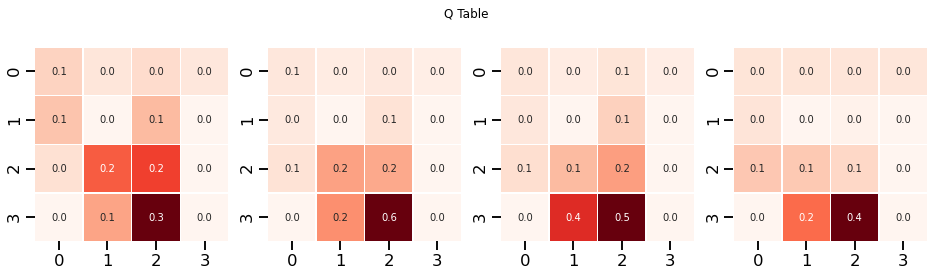

In [95]:
q_array_history = []
alpha_history = []
reward_history_sarsa=[]
env._max_episode_steps = 1000
# Use SARSA to update Q_array:
q_array = sarsa(env, epsilon=0.5, display=False)
env.close()
#Display the Q_table:
qtable_display(q_array, title="Q Table", cbar=True)

### Evaluate Policy with Gym

Run the next cell to count the number of successful trials of SARSA on 1000 episodes.

**Note**: OpenAI considers the task is solved if you reach 76\% of success over the episodes.

In [96]:
env = gym.make('FrozenLake-v1')
env._max_episode_steps = 1000

reward_list = []
NUM_EPISODES = 5000

for episode_index in range(NUM_EPISODES):
    state = env.reset()
    done = False
    while not done:
        action = greedy_policy(state, q_array)
        state, reward, done, info = env.step(action)
    reward_list.append(reward)
reward_df = pd.DataFrame(reward_list)
print('Average reward (which is equivalent to a "success rate" in the FrozenLake environment as the total rewards in this environment are either 0 or 1):', np.average(reward_df))
env.close()

Average reward (which is equivalent to a "success rate" in the FrozenLake environment as the total rewards in this environment are either 0 or 1): 0.7512


### Exercise 3: Implement the QLearning algorithm

## Exercise 3: Implement the Q-LEARNING algorithm


SARSA is an on-policy method. In this exercise, we implement Q-learning: an **off-policy** method: Q-learning doesn't estimate the Q-function of its current policy but it estimates the value *the optimal one*.

To do so, it uses the following update rule:
$$
Q_{t+1}(S_t,A_t) \leftarrow Q_t(S_t, A_t) + \alpha \left( r_t + \gamma \underbrace{\max_a Q_t(S_{t+1}, a)}_{\textrm{different from SARSA}} - Q_t(S_t, A_t) \right) .
$$

Intuitively, Q-learning is "being greedy" and chooses the $\textrm{argmax}_a Q(S,a)$ action (instead of choosing the next action by current policy like SARSA).

---
QLearning


<b>Algorithm parameter</b>:
	$\quad\quad$ discount factor $\discount$,
	$\quad\quad$ step size $\stepsize \in (0,1]$ ,
	$\quad\quad$ small $\epsilon > 0$,
	
**Initialize** $\qtable(\state, \action) =0, ~~~ \forall \state \in \statespace, \action \in \actionspace(\state)$<br>

<b>FOR EACH</b> episode<br>
	$\quad$ $\statet \leftarrow \text{env.reset}()$<br>
	$\quad$ <b>DO the following  <b>UNTIL</b> $\statet$ is final:</b> <br>
		$\quad\quad$ $\actiont \leftarrow \epsilon\text{-greedy}(\statet, Q)$<br>
		$\quad\quad$ $\reward, \newstatet \leftarrow \text{env.step}(\actiont)$<br>
		$\quad\quad$ $Q(\statet,\actiont) \leftarrow Q(\statet,\actiont) + \stepsize \left[ \underbrace{\reward + \discount ~ \max_{\action} Q(\newstatet, \action) ~ - ~ Q(\statet,\actiont)}_{\text{TD error}} \right]$<br>
		$\quad\quad$ $\statet \leftarrow \newstatet$<br>
	

**QUESTION 3.1.** In the next cell, you need to fill in the blank to implement the Q-LEARNING algorithm:

In [97]:
DISPLAY_EVERY_N_EPISODES = 50

def q_learning(env, alpha_init=0.1, gamma=0.99, epsilon=0.5, num_episodes=10000, display=False):
    num_states = env.observation_space.n
    num_actions = env.action_space.n
    q_array = np.zeros([num_states, num_actions])   # Initial Q table
    accum_reward = 0
    alpha = alpha_init

    for episode_index in range(num_episodes):
        # For displaying purpose:  
        if display and episode_index % DISPLAY_EVERY_N_EPISODES == 0:
            qtable_display(q_array, title="Q table", cbar=True)
        else: print('', end="")
        q_array_history.append(q_array.copy())
        alpha_history.append(alpha)
        reward_history_qlearning.append(accum_reward)
        
        
        ### BEGIN EXERCISE ###

        # Step 0:Write your update-rule of stepsize alpha here
        aplha = pow(0.998, episode_index)


        is_final_state = False
        state = env.reset()

        while not is_final_state:
            # We take action from epsilon-greedy INSIDE the while-loop (unlike SARSA doing this outside of while-loop)
            action = epsilon_greedy_policy(state, q_array, epsilon)
            # Filling in the blank:
            # Step 1: Sample new_state, reward via env.step(action):            
            new_state, reward, is_final_state, info = env.step(action)
                     
            
            # Step 3: Update the q_array (at the state and action) via TD-update:
           
 
            # Step 2: Find the max_action = max_a (q_array[new_state, a]). 
            # Hints: you can use the greedy_policy function defined above:         
            max_action = greedy_policy(new_state, q_array)
            
            # Step 3: TD-Update with max_action:
            q_array[state, action] += alpha*( reward +gamma*q_array[new_state, max_action]- q_array[state, action]) 

 

            ### END EXERCISE ###



            # Re-assign new_state to state:
            state = new_state
        
        accum_reward += reward  # For comparison purpose in Bonus question
    return q_array

**Task**: In the next cell, we run Q_LEARNING and assign its output to ```q_array```.

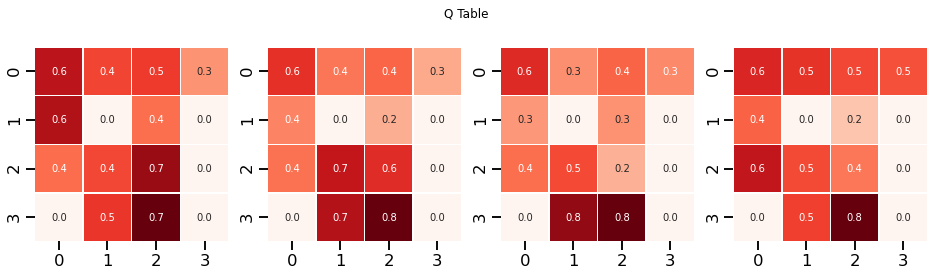

In [98]:
q_array_history = []
alpha_history = []
reward_history_qlearning=[]

env._max_episode_steps = 1000
q_array = q_learning(env, display=False)
env.close()
qtable_display(q_array, title="Q Table", cbar=True)

### Evaluate Policy with Gym

As a measure of performance, run the next cell to count the number of successful trials of Q-learning on 1000 episodes.

**Note**: OpenAI considers the task is solved if you reach 76\% of success over the episodes.

In [99]:
environment = gym.make('FrozenLake-v1')
environment._max_episode_steps = 1000
reward_list = []
NUM_EPISODES = 5000
for episode_index in range(NUM_EPISODES):
    state = environment.reset()
    done = False
    #t = 0
    while not done:
        #action = epsilon_greedy_policy(state, q_array, epsilon)
        action = greedy_policy(state, q_array)
        state, reward, done, info = environment.step(action)
    reward_list.append(reward)
reward_df = pd.DataFrame(reward_list)
print('Average reward (which is equivalent to a "success rate" in the FrozenLake environment as the total rewards in this environment are either 0 or 1):', np.average(reward_df))
environment.close()

Average reward (which is equivalent to a "success rate" in the FrozenLake environment as the total rewards in this environment are either 0 or 1): 0.8224


**Question**: Which algorithm you think performs better SARSA or Q-LEARNING (given the same number of training episodes and alpha update rule)? (To mitigate the randomness, we should check the success rate in a large number of episodes).

### Bonus question: Compare SARSA and Q-LEARNING in training:
In the next cell, we plot out the accumulated reward while **training** the algorithms. Which one do you think perform worse in the beginning of the training? Any explanation for this?

CONCLUSION:
* Use SARSA when we "care" about the performance while training
* Use Q-Learning when we "do not care" about the performance while training.





Text(0, 0.5, 'accumulated reward')

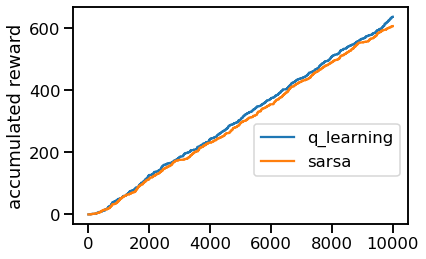

In [100]:
f,ax = plt.subplots()
ax.plot(reward_history_qlearning)
ax.plot(reward_history_sarsa)
ax.legend(['q_learning', 'sarsa'],bbox_to_anchor=(1, 0.5))
ax.set_ylabel('accumulated reward')

**ANSWERS FOR BONUS QUESTION**:

As we can notice, Q-learning outperforms slightly Sarsa while the number of iteration increases. 

**To recall** Q-learning method is OFF-policy as target policy is different from behavior policy. While Sarsa is ON-policy because both target and behavior policy are the same.

Maybe it's because in this case of study, q-learning goes through the shortest and better path to reach the optimal solution. In other terms, it does not fall in the cliff while reaching the goal. 

However, in this case of study we can not conclude either sarsa or q learning is better because if we re-run multiple times the code above, sometimes we get sarsa bettet than q-learning, in other times we get the opposite. The reason may be related to the environment having a limited number of states an actions. So, we can not really evaluate the difference between the 2 methods.